# High dimensional combution chemical data clustering
In combustion simulation a singal chemical state in space and time is represented by a high dimensional vector of mass farctions. When analyzing the results, usually all the mass fraction are investigated separately. Such analyzation is missing the corrolation in the high dimenion space. In this work, different mathematical tools are used to cluster the high dimension data. The study is to find out how the clustering is related to different regime in combustion. And it is hoped different models will have distinct feature in such sub-cluster. 

Unsupervised learning has many challenges for predictive analytics — including not knowing what to expect when you run an algorithm. Each algorithm will produce different results; you’ll never be certain whether one result is better than the other — or even whether the result is of any value.

When you know what the outcomes should be, you can tweak the algorithms to produce the desired outcomes. In real-world datasets, you won’t have this luxury. You’ll have to depend on some prior knowledge of the data — or intuition — to decide which initialization parameters and algorithms to use as you create your model.

In real unsupervised learning tasks, however, this prior knowledge is unavailable and the desired result is difficult to find. Choosing the right number of clusters is the key problem. If you happen to stumble upon the right number of clusters, your data will yield insights which you can make highly accurate predictions. On the flip side, guessing the wrong number of clusters may yield subpar results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd

import os
from scipy import interpolate

## 2d contour plot for axial and radial planes
Slices of the tnf partially premixed flame simulation are studied here. Stochastic fields method with 8 fields are used in the simulation.  

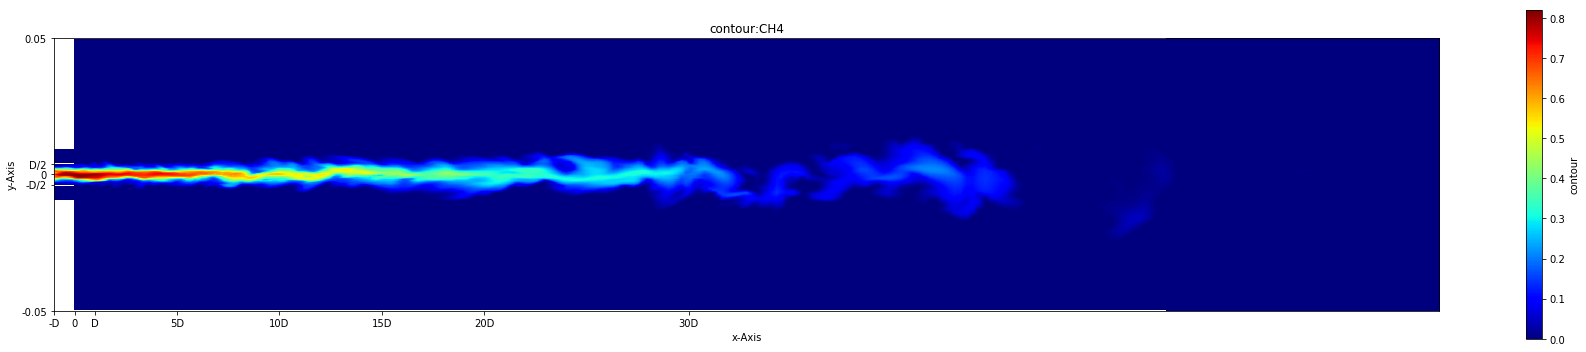

In [2]:
from bc import read_data, plot_contour
data_name = 'plane_xy_00.csv'
df, mesh = read_data(data_name)
plot_contour(data_name,mesh,df['CH4'])

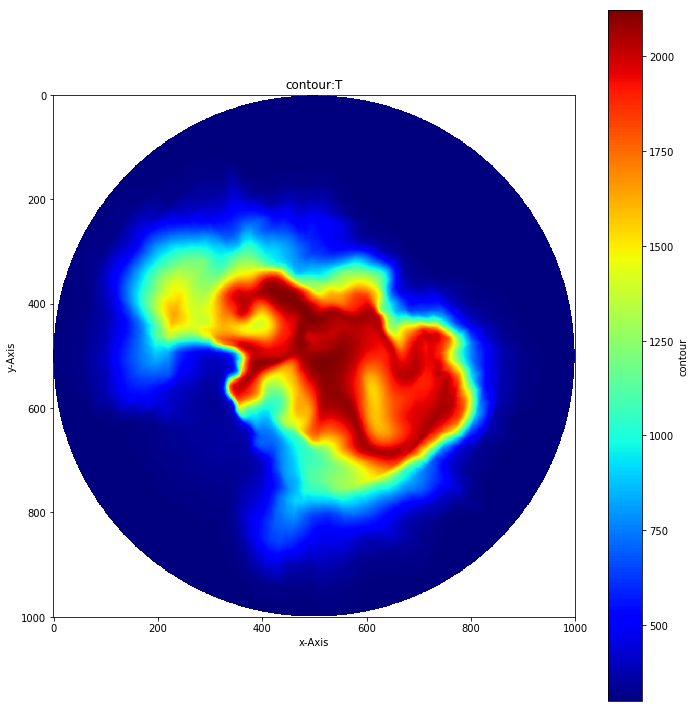

In [3]:
data_name = 'plane_yz_50.csv'
df, mesh = read_data(data_name)
plot_contour(data_name,mesh,df['T'])

## Kmeans and DBSCAN
kmeans is the most common clustering algorithsms.K-means is widely employed to solve big-data problems because it’s simple to use, effective, and highly scalable. No wonder most commercial vendors use the K-means algorithm as a key component of their predictive analytics packages.

In [4]:
from bc import clustering, plot_cluster, plot_scatter
from sklearn.cluster import KMeans,DBSCAN
import hdbscan
data_name = 'plane_yz_50.csv'
df, mesh = read_data(data_name)

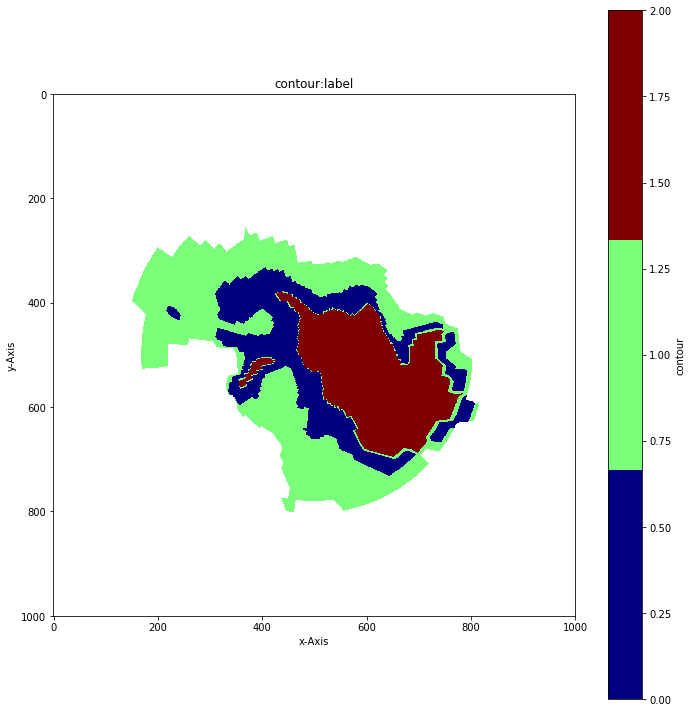

,0,1,2
0,1.000000,1.000,2.00000
1,0.969774,0.998,0.98886
2,6428.000000,3906.000,9666.00000


In [5]:
dsc=df.copy()
kmeans = KMeans(n_clusters=3, random_state=42)
df,cmap,cluster = clustering(df,dsc,kmeans)
plot_contour(data_name, mesh, df['label'], mask=df['f_Bilger'] < 0.01,cmap=cmap)
# plot_scatter(df, 'T', method='kmeans')
cluster.head()
# plot_cluster(data_name, mesh, dsc, kmeans,method='kmeans')

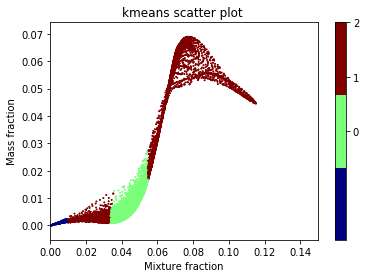

In [6]:
plot_scatter(df, 'CO',method='kmeans')

The DBSCAN (Density-Based Spatial Clustering of Applications with Noise) implementation in scikit-learn does not require any user-defined initialization parameters to create an instance. You can override the default parameters during initialization if you want. Unfortunately, if you’re using the default parameters, the algorithm can’t provide a close match to the desired outcome.

DBSCAN is better suited for datasets that have disproportional cluster sizes, and whose data can be separated in a non-linear fashion. Like K-means, DBSCAN is scalable, but using it on very large datasets requires more memory and computing power.

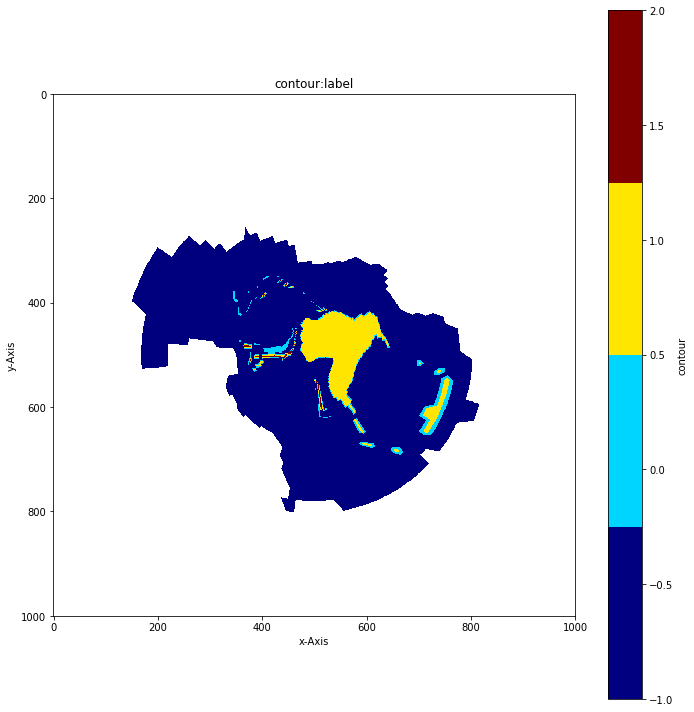

,0,1,2,-1
0,2.000000,1.000000,2.000000,2.000000
1,0.998466,0.985573,0.997181,0.988479
2,400.000000,5854.000000,250.000000,13496.000000


In [7]:
dbscan = DBSCAN(eps=0.002, min_samples=200)
df,cmap,cluster = clustering(df,dsc,dbscan)
plot_contour(data_name, mesh, df['label'], mask=df['f_Bilger'] < 0.01,cmap=cmap)
cluster.head()


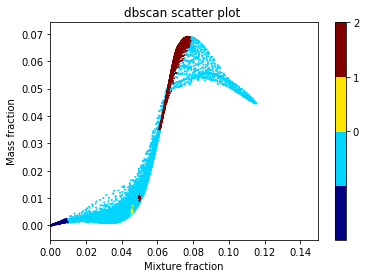

In [8]:
plot_scatter(df, 'CO',method='dbscan')

By comparing kmeans and DBSCAN, it is interesting to see that the two method produced very different results. As shown in the scatter plot, Kmeans has split the reaction zone into two regions, while DBSCAN has a cluster that covers the entire rection zone. The same feature could be seen from the radial contour. The CH4 contour shows a spot of high concentration of fuel and relatively weaker reaction. Such pocket has been reflacted in the DBSCAN clustering algorithsm but has not been picked up by Kmeans.

## data scaling
scaling the data before clustering will affect the results. 
There are three popular scaling method.
* Centering
It scale the data by subtract the min

$x-\bar x$

* Unit Variance
It scale the centered data by its variance. So all features will have a unit variance.

$\frac{x -\bar x}{variance}$

* PARETO
It scales the centered data by the standard diviation.

$\frac{x -\bar x}{\sqrt{variance}}$

Using 'Auto' scaling will help kmeans to locate the reaction zone
### radial plot analysis

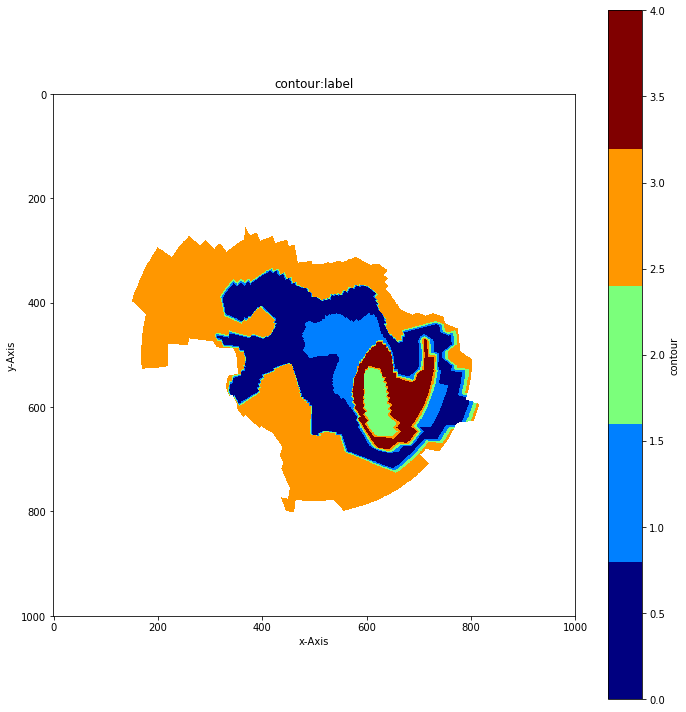

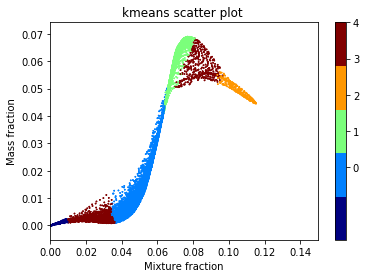

,0,1,2,3,4
0,3.000000,3.000000,2.00000,3.000000,3.000000
1,0.989278,0.982317,0.98862,0.981304,0.973894
2,9058.000000,5218.000000,498.00000,4408.000000,818.000000


In [9]:
from data_clustering import data_scaling
data_name = 'plane_yz_50.csv'
df, mesh = read_data(data_name)
dsc = data_scaling(df,'Auto')
kmeans = KMeans(n_clusters=5, random_state=42)
df,cmap,cluster = clustering(df,dsc,kmeans)
plot_contour(data_name, mesh, df['label'], mask=df['f_Bilger'] < 0.01,cmap=cmap)
plot_scatter(df, 'CO',method='kmeans')
kmeans_label_r=df['label'].copy()
df_r=df.copy()
cluster.head()

However when combined with 'Auto' scaling, DBSCAN can identify the thin 'flamelet' layer.

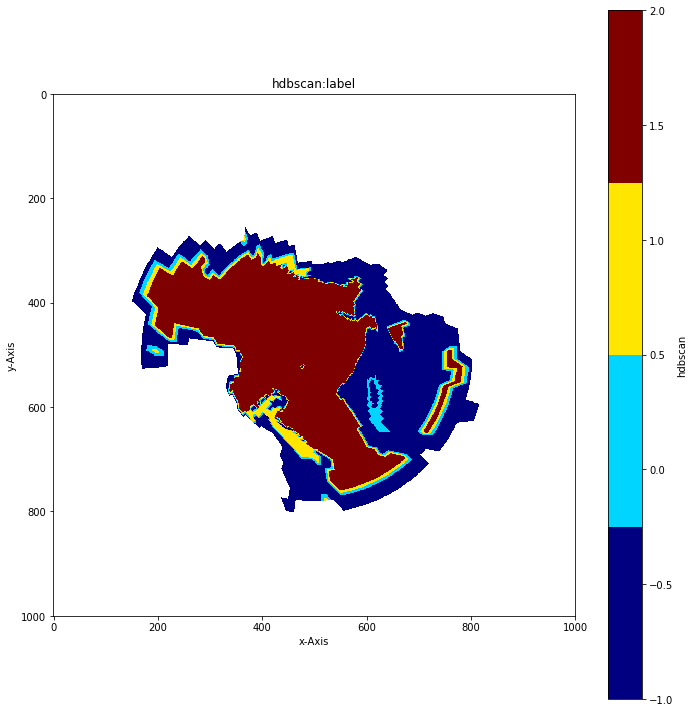

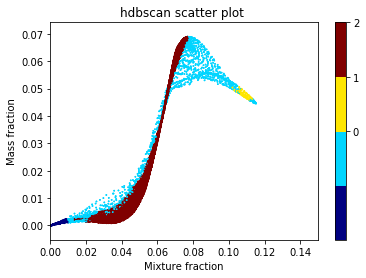

,0,1,2,-1
0,2.000000,2.000000,3.000000,4.000000
1,0.959773,0.954354,0.953593,0.950509
2,204.000000,374.000000,15880.000000,3542.000000


In [10]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=200)
df,cmap,cluster = clustering(df,dsc,hdbscan_model)
plot_contour(data_name, mesh, df['label'], mask=df['f_Bilger'] < 0.01,cmap=cmap,method='hdbscan')
plot_scatter(df, 'CO',method='hdbscan')
dbscan_label_r=df['label'].copy()
cluster.head()

### axial contour analysis

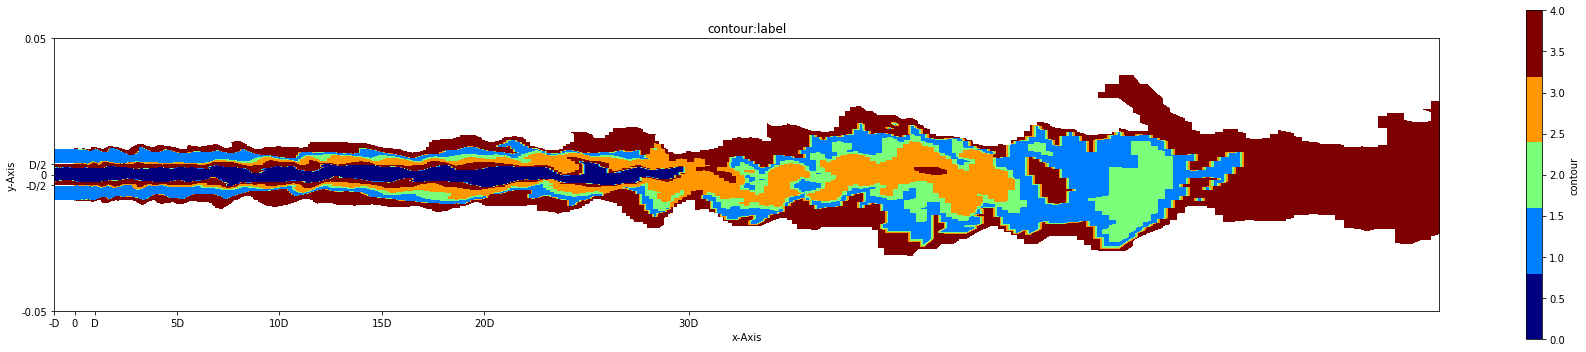

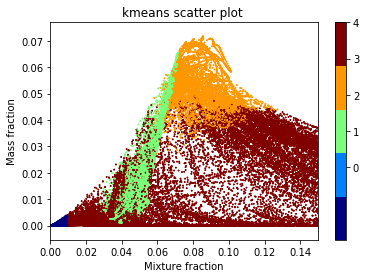

,0,1,2,3,4
0,2.000000,3.000000,4.000000,4.000000,4.000000
1,0.992523,0.953178,0.961263,0.958422,0.953342
2,24011.000000,28097.000000,10894.000000,24526.000000,48720.000000


In [11]:
data_name = 'plane_xy_00.csv'
df, mesh = read_data(data_name)
dsc = data_scaling(df,'Auto')
kmeans = KMeans(n_clusters=5, random_state=42)
df,cmap,cluster = clustering(df,dsc,kmeans)
plot_contour(data_name, mesh, df['label'], mask=df['f_Bilger'] < 0.01,cmap=cmap)
plot_scatter(df, 'CO',method='kmeans')
kmeans_label_x=df['label'].copy()
df_x=df.copy()
cluster.head()

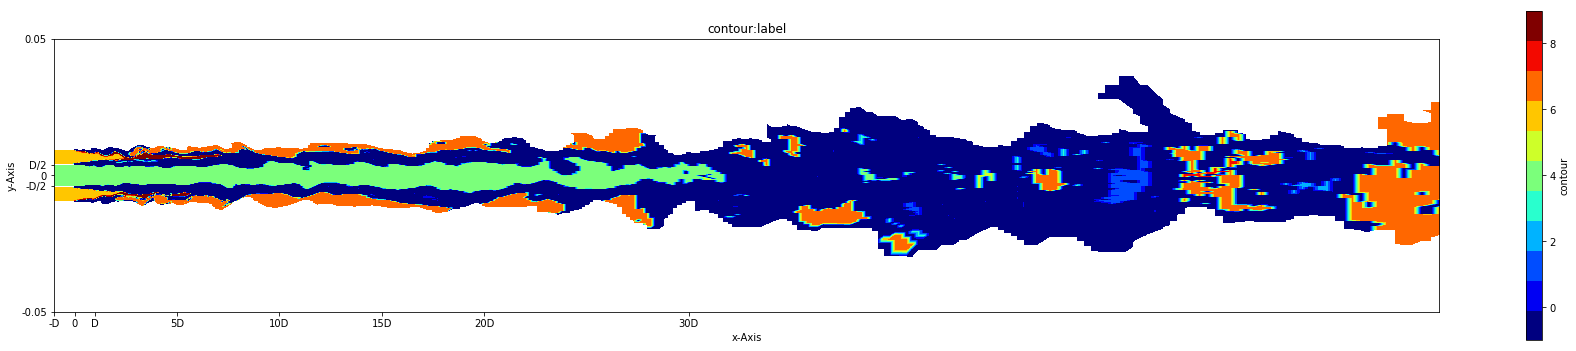

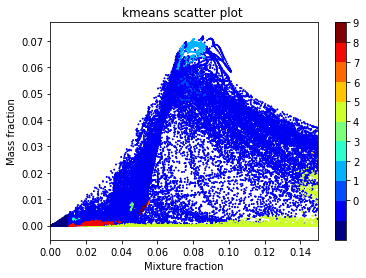

,0,1,2,3,4,5,6,7,8,9,-1
0,3.000000,2.000000,4.000000,2.000000,2.000000,4.000000,1.000000,3.000000,3.000000,2.000000,7.000000
1,0.968816,0.985975,0.998671,0.981587,0.980064,0.969643,0.972724,0.991027,0.995936,0.972282,0.960235
2,376.000000,1126.000000,208.000000,400.000000,38355.000000,202.000000,4682.000000,16458.000000,309.000000,1812.000000,72320.000000


In [12]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=200)
df,cmap,cluster = clustering(df,dsc,hdbscan_model)
plot_contour(data_name, mesh, df['label'], mask=df['f_Bilger'] < 0.01,cmap=cmap)
plot_scatter(df, 'CO',method='kmeans')
hdbscan_label_x=df['label'].copy()
cluster.head()

## Comparing clusters to flow turbulence information
DBSCAN cluster captured chi difference. In the clustering so far, only the chemical state is used. Showing from the conditional scatter plot, Kmeans works well in differentiate different combustion regimes. When tubulence information is added to the analysis, it demonstrate that the density based clustering, though given no specific flow information, is able to cluster observation according to the scalar dissipation rate $\chi$

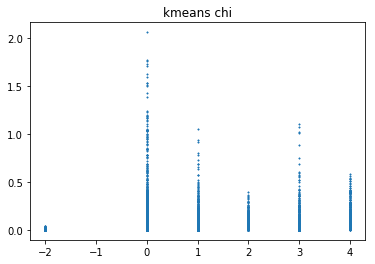

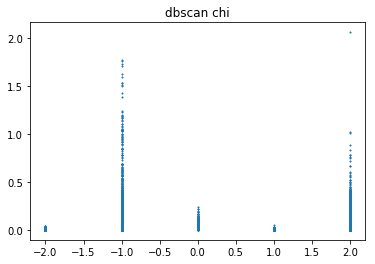

In [13]:
plt.scatter(kmeans_label_r,df_r['Chi'],s=0.5)
plt.title('kmeans chi')
plt.show()
plt.scatter(dbscan_label_r,df_r['Chi'],s=0.5)
plt.title('dbscan chi')
plt.show()

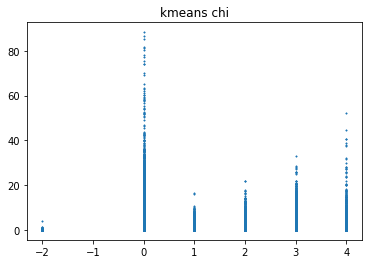

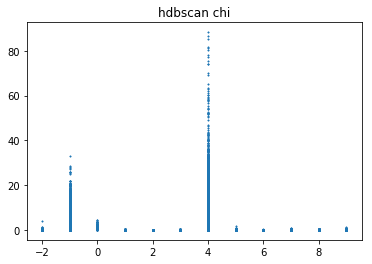

In [14]:
plt.scatter(kmeans_label_x,df_x['Chi'],s=0.5)
plt.title('kmeans chi')
plt.show()
plt.scatter(hdbscan_label_x,df_x['Chi'],s=0.5)
plt.title('hdbscan chi')
plt.show()

## pca analysis

variance: 0.856287306978


<IPython.core.display.Javascript object>


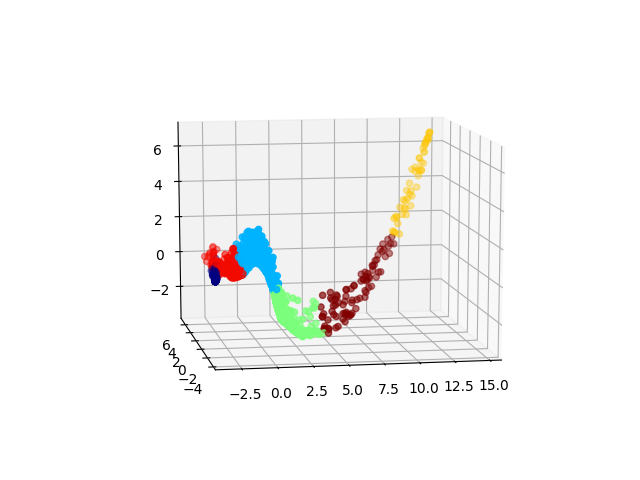

In [23]:
%matplotlib notebook
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
dsc = data_scaling(df_r, 'Auto')

drop = ['ccx', 'ccy', 'ccz', 'label',
            'T', 'Chi', 'PV',
            'f_Bilger', 'non-eq', 'PV_norm', 'Chi_norm', 'PV_compute'
            ]
drop = set(dsc.columns).intersection(drop)
dsc=dsc.drop(drop,axis=1)

dsc_s=dsc.sample(frac=0.1)
pca= PCA(n_components=3)
a=pca.fit_transform(dsc_s)
print('variance:',sum(pca.explained_variance_ratio_))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a[:,0],a[:,1],a[:,2],c=df_r.loc[dsc_s.index]['label'],cmap=cmap)
plt.show()